In [1]:
%matplotlib inline
import sys, time
import pyopencl as cl
import tables
import numpy as np
# import scipy.misc as scp
import matplotlib.pyplot as plt

from PIL import Image

In [2]:
def init_data(population_size, resolution):
    population = np.zeros((population_size, 16), dtype=np.int32)

    max_power = 364
    max_mass = 364

    res_x = resolution[0]
    res_y = resolution[1]
    res_z = resolution[2]

    #initial position
    population[:,0] = np.random.randint(res_x, size=population_size)[:]

    population[:,1] = np.random.randint(res_y, size=population_size)[:]

    population[:,2] = np.random.randint(res_z, size=population_size)[:]
    
    #velocity + position provides vector - i.e. initial debt
    population[:,3] = 0
    population[:,4] = 0
    population[:,5] = 0

    #mass, power randomized? should be part of genome - eventually?
    population[:,6] = np.random.randint(max_power/4, max_power, size=population_size)[:]

    population[:,7] = np.random.randint(max_mass/4, max_mass, size=population_size)[:]
    
    #genomic weights to be used as bytestrings
    population[:,8:16] = 0 

    return population

In [3]:
def im(population, resolution, col=None):
    res_x = resolution[0]
    res_y = resolution[1]
    
    if col is None:
        col = np.asarray([[255,255,255],])
    
    flat_world = np.zeros((res_x,res_y,3), dtype=np.uint8)
    
    flat_world[population[:,0],population[:,1],0] = col[:,0]
    flat_world[population[:,0],population[:,1],1] = col[:,1]
    flat_world[population[:,0],population[:,1],2] = col[:,2]
    return flat_world

In [4]:
def draw(population, resolution, count):
    res_x = resolution[0]
    res_y = resolution[1]

    flat_world = np.zeros((res_x, res_y), dtype=bool)
    flat_world[population[:,0],population[:,1]] = 1
    img = Image.fromarray(flat_world.astype(np.bool))
    img.save("./out/image/frame_{0:05d}.png".format(count))
#     scp.imsave("./out/image/frame_{0:05d}.png".format(count),flat_world.astype(bool))

In [5]:
def form_world(population, resolution):
    res_x = resolution[0]
    res_y = resolution[1]
    res_z = resolution[2]

    world = np.zeros((res_x, res_y, res_z), dtype=np.int32)
    world[population[:,0],population[:,1], population[:,2]] = 1
    return world

In [6]:
def save_as_hd5(population, resolution, filepath=None):
    if filepath:
      h5_out = tables.open_file(filepath, mode='w', title="Starlings")
    else:
      h5_out = tables.open_file('./starlings.h5', mode='w', title="Starlings")
    root = h5_out.root
    h5_out.create_array(root, "population", population)
    h5_out.create_array(root, "resolution", resolution)
    h5_out.close()

In [7]:
def read_from_hd5(filepath=None):
    if filepath:
      h5_in = tables.open_file(filepath, mode='r')
    else:
      h5_in = tables.open_file('./starlings.h5', mode='r')
    population = h5_in.get_node("/population").read()
    resolution = h5_in.get_node("/resolution").read()
    h5_in.close()
    return population, resolution

In [8]:
class OpenCl(object):
    def __init__(self):
        self.ctx, self.queue = self.cl_init()
        self.program = self.cl_load_program("./kernal.cl")

    def cl_init(self):
        platforms = cl.get_platforms()
        ctx = cl.create_some_context()
        queue = cl.CommandQueue(ctx)
        return ctx, queue

    def cl_load_program(self, filepath):
        f = open(filepath, 'r')
        fstr = "".join(f.readlines())
        program = cl.Program(self.ctx, fstr).build()
        return program

    def cl_load_data(self, population, world):
        mf = cl.mem_flags
        out = cl.Buffer(self.ctx, mf.WRITE_ONLY, population.nbytes)
        population_cl = cl.Buffer(self.ctx, mf.READ_ONLY | mf.COPY_HOST_PTR, hostbuf=population)
        world_cl = cl.image_from_array(self.ctx, world, mode="r")
        return population_cl, world_cl, out

    def execute(self, num, population, world, inner_rad, outer_rad):
        population_cl, world_cl, out = self.cl_load_data(population, world)

        world_x = np.int32(world.shape[0])
        world_y = np.int32(world.shape[1])
        world_z = np.int32(world.shape[2])

        constants = np.asarray([0, 0], dtype=np.int32)

        ret = np.zeros_like(population)        

        global_size = ((num),)
        local_size = None

        kernalargs = (
                      population_cl,
                      out,
                      world_cl,
                      world_x, world_y, world_z,
                      inner_rad, outer_rad
                     )

        image_sequence = []

        self.program.knn(self.queue, global_size, local_size, *(kernalargs)).wait()
        cl.enqueue_copy(self.queue, ret, out)
        #cl.enqueue_read_buffer(self.queue, out, ret)


        #supersitious drivel!
        out.release()
        population_cl.release()
        world_cl.release()
        
        #self.queue.finish()
        return ret

In [9]:
def plot_(starlings, resolution, count):
    plt.figure(figsize = (20,20))
    
    plt.imshow(im(starlings,resolution), interpolation='nearest')
    
    plt.plot([starlings[1066,1],(starlings[1066,1] - starlings[1066,4])], 
             [starlings[1066,0],(starlings[1066,0] - starlings[1066,3])], 
             lw="3", c='red')
    plt.plot([starlings[1067,1],(starlings[1067,1] - starlings[1067,4])], 
             [starlings[1067,0],(starlings[1067,0] - starlings[1067,3])], 
             lw="3", c='green')
    plt.plot([starlings[1068,1],(starlings[1068,1] - starlings[1068,4])], 
             [starlings[1068,0],(starlings[1068,0] - starlings[1068,3])]
             , lw="3", c='magenta')
    
    plt.scatter((starlings[1066,1] - starlings[1066,4]),
                (starlings[1066,0] - starlings[1066,3]), 
                s=600, c='red', alpha=.5, marker='d')
    plt.scatter((starlings[1067,1] - starlings[1067,4]),
                (starlings[1067,0] - starlings[1067,3]), 
                s=600, c='green', alpha=.5, marker='d')
    plt.scatter((starlings[1068,1] - starlings[1068,4]),
                (starlings[1068,0] - starlings[1068,3]), 
                s=600, c='magenta', alpha=.5, marker='d')
    
    plt.scatter(starlings[1066,1], starlings[1066,0], s=600, c='red', )
    plt.scatter(starlings[1067,1], starlings[1067,0], s=600, c='green')
    plt.scatter(starlings[1068,1], starlings[1068,0], s=600, c='magenta')
    
    plt.title(str(count), size=64)
    
    return plt

In [10]:
def filter_velocity(starlings, limit):
    s_ind = np.where(
        (starlings[:,3] > (-1 * fi)) & 
        (starlings[:,3] < (fi)) & 
        (starlings[:,4] > (-1 * fi)) & 
        (starlings[:,4] < (fi)))[0]
    return starlings[s_ind]

0


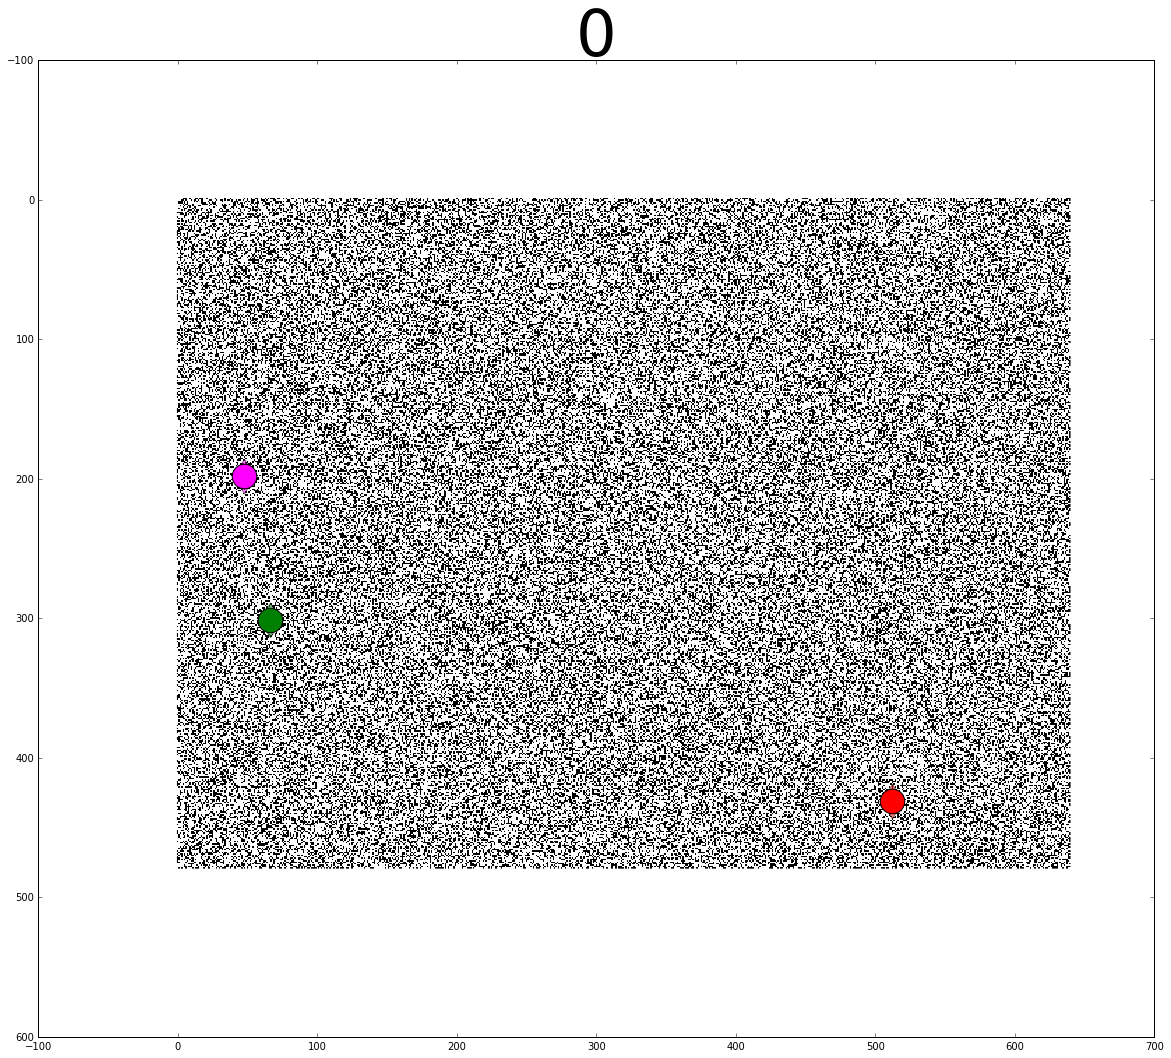

1


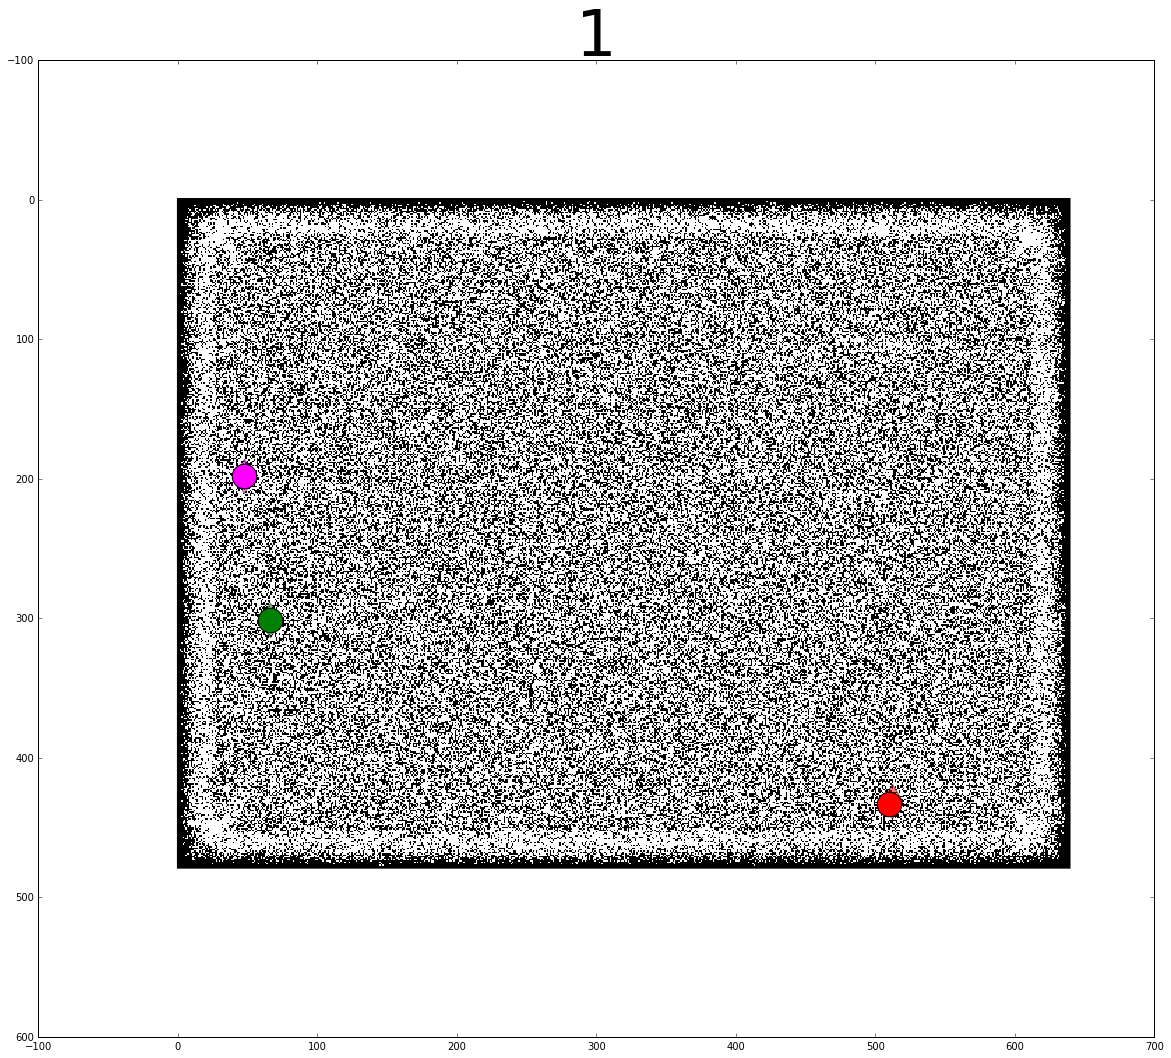

2


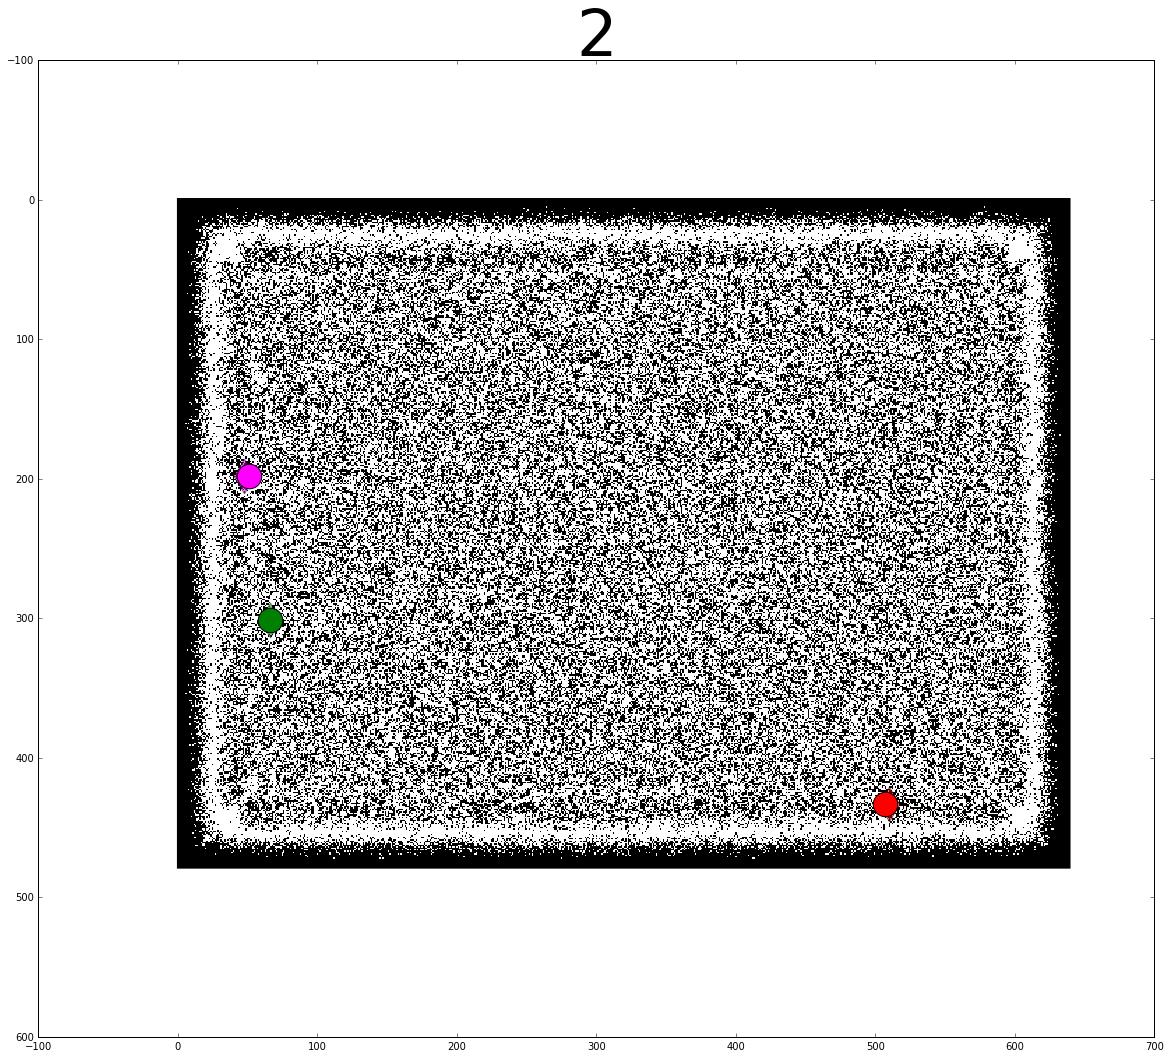

3


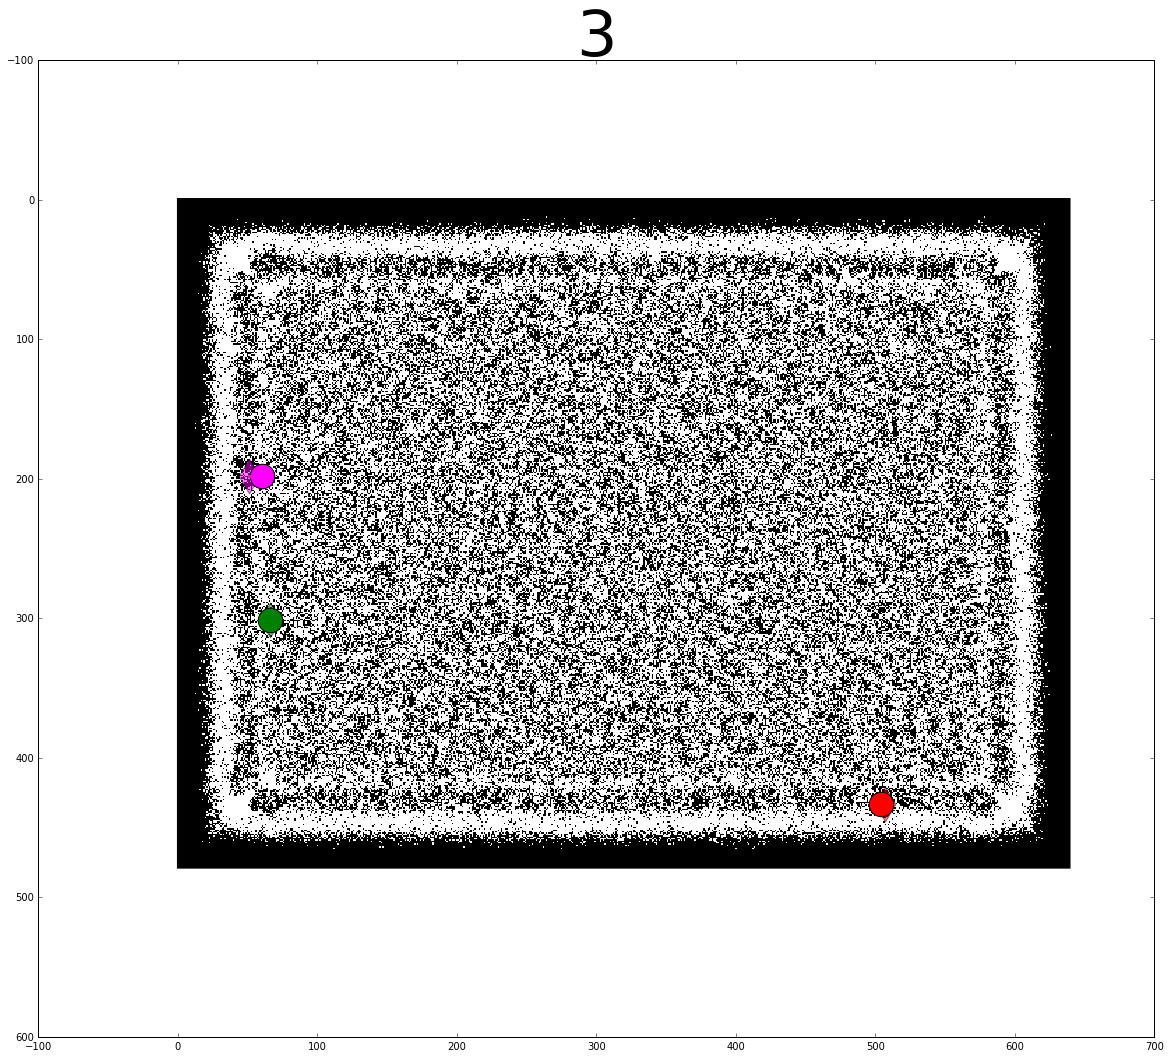

4


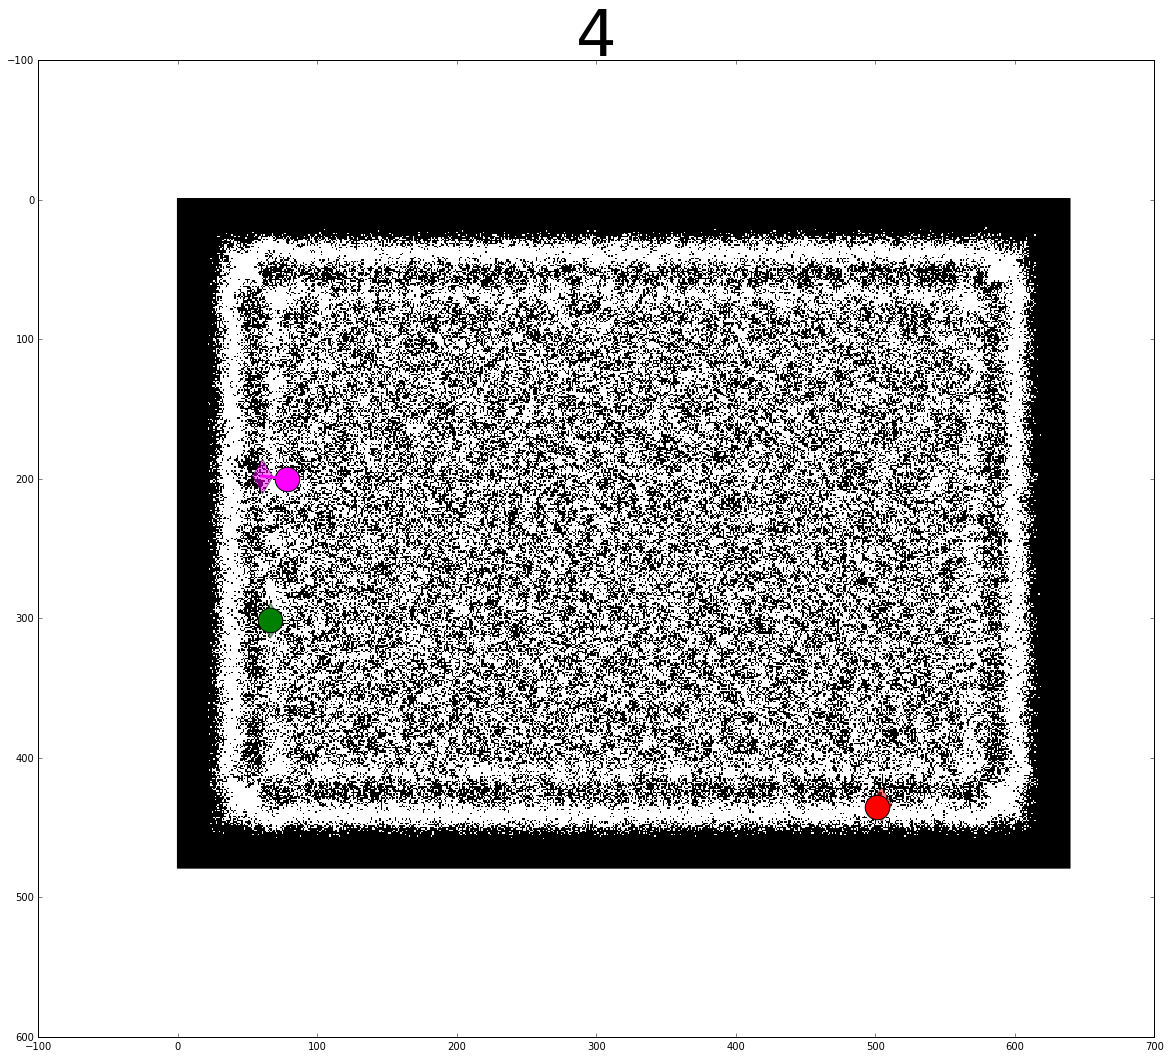

5


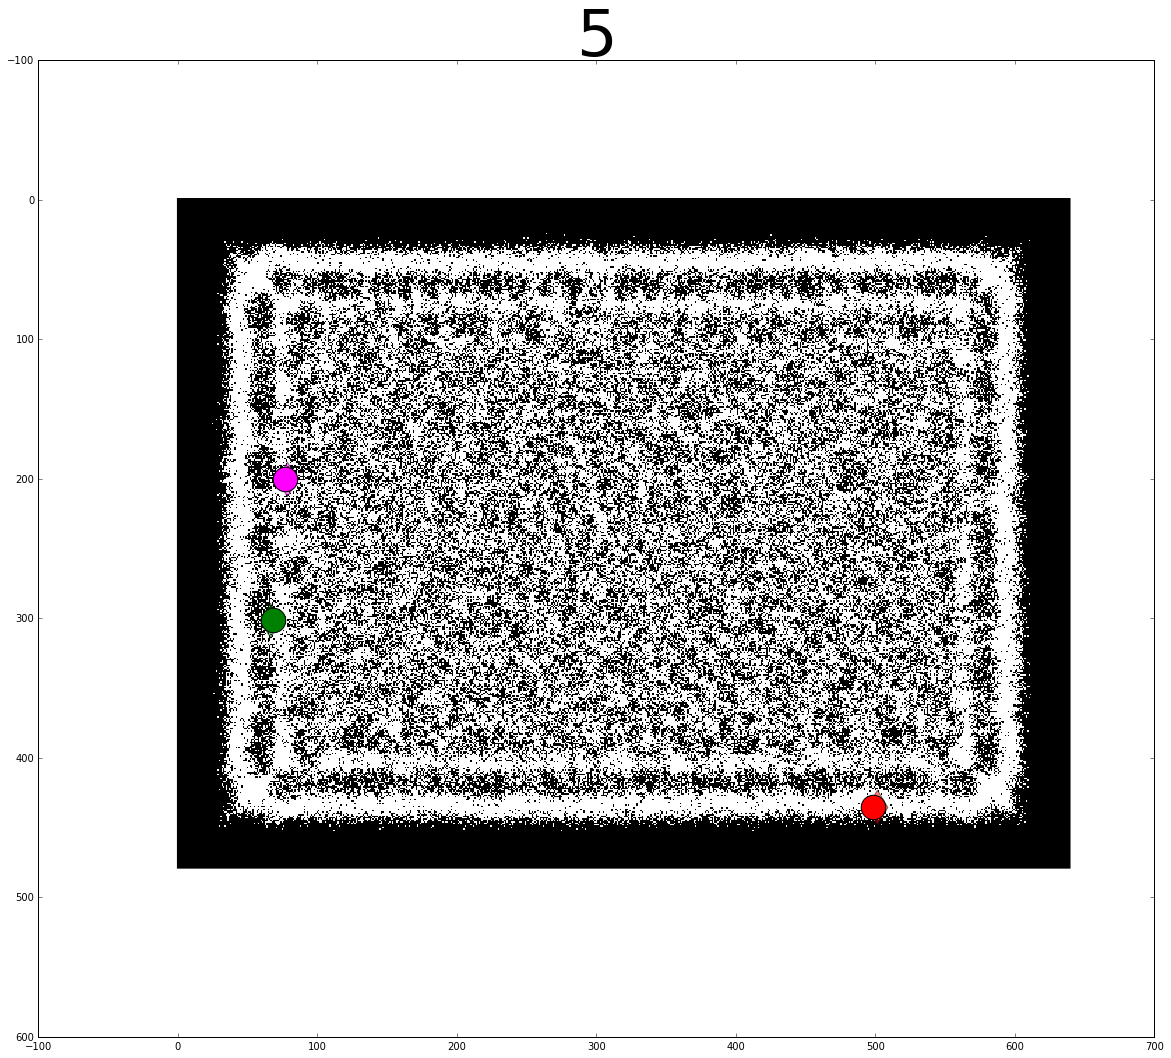

6


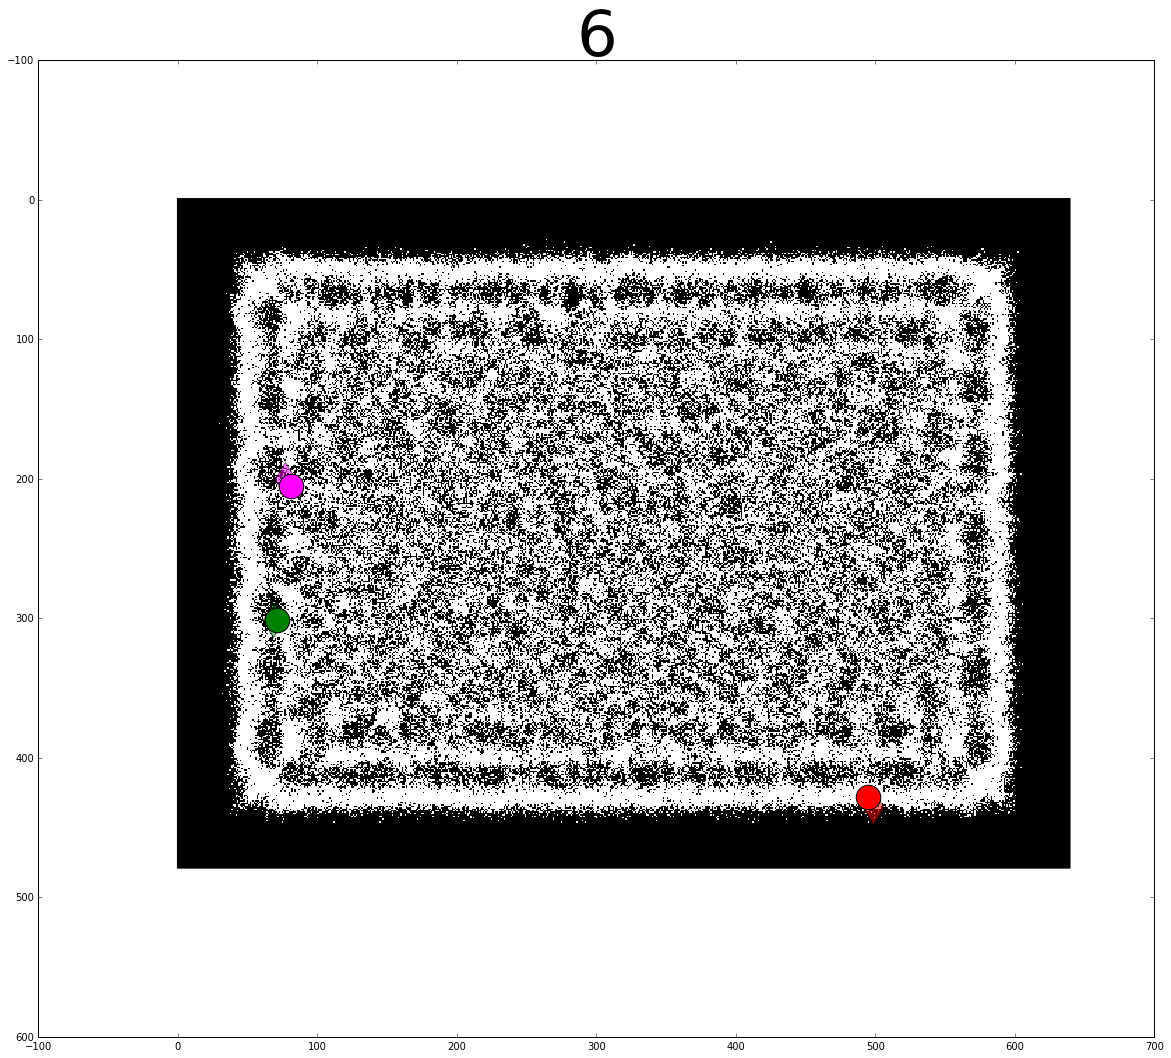

7


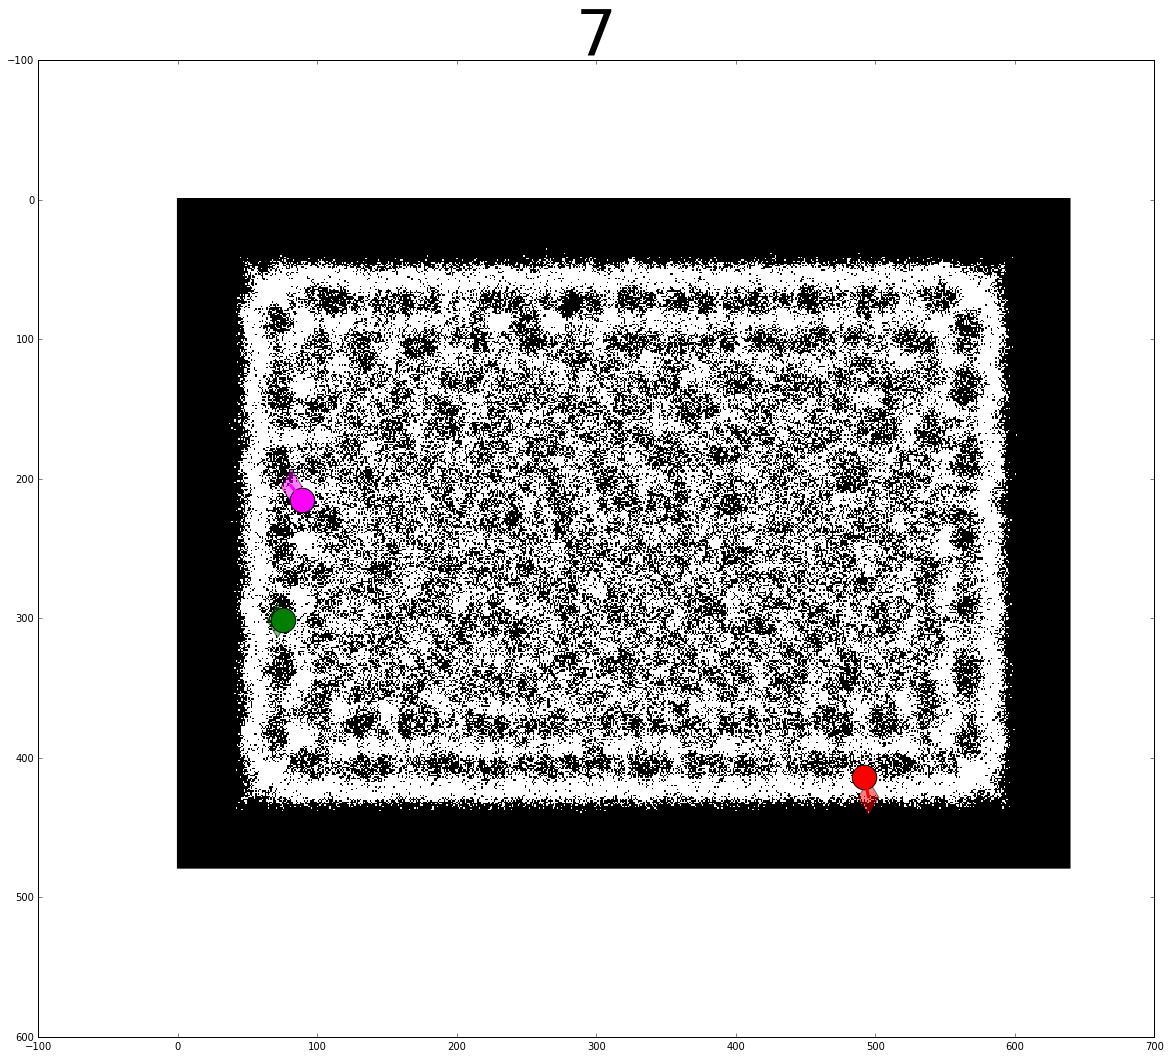

8


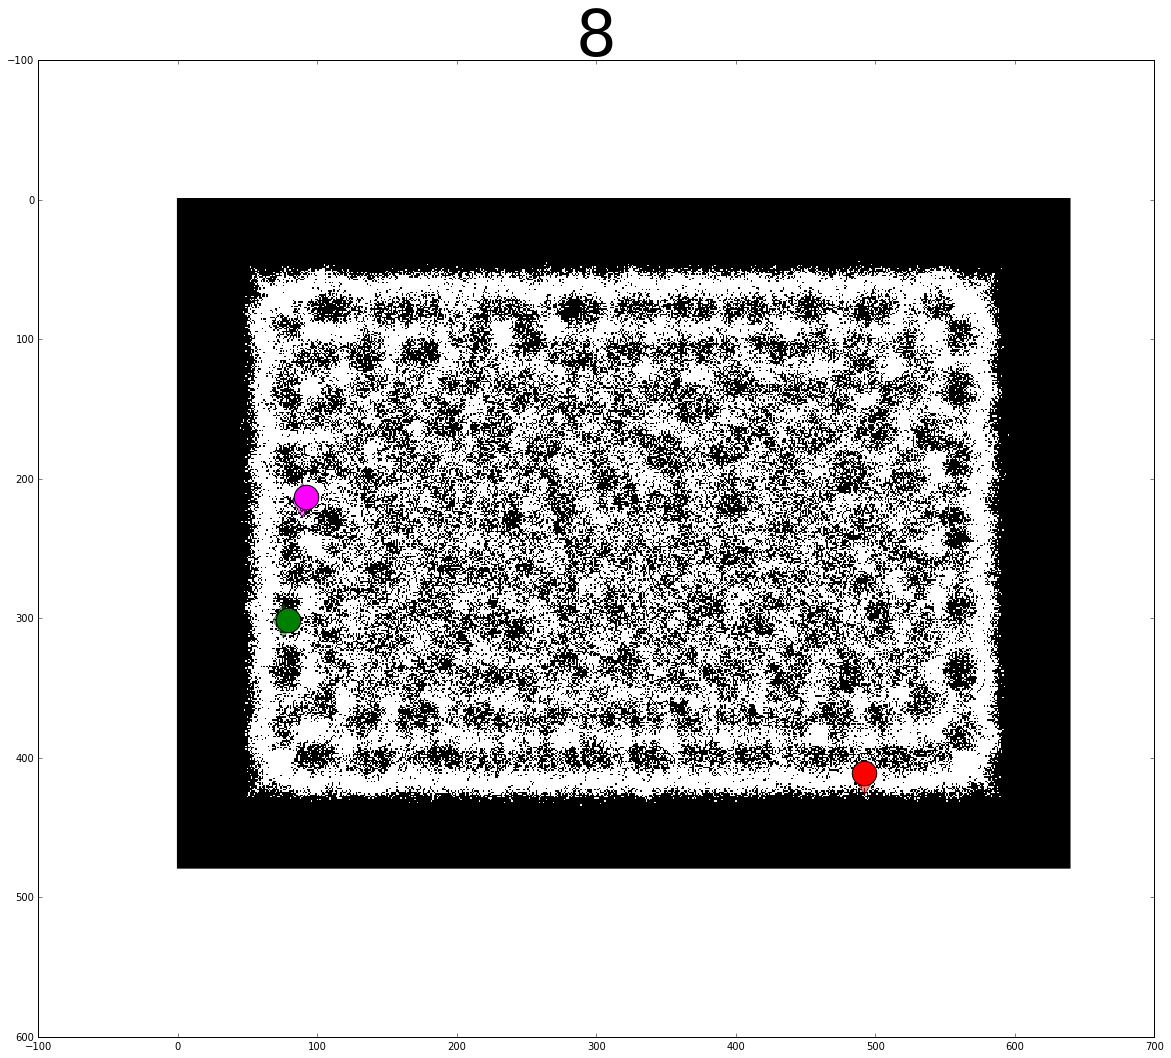

9


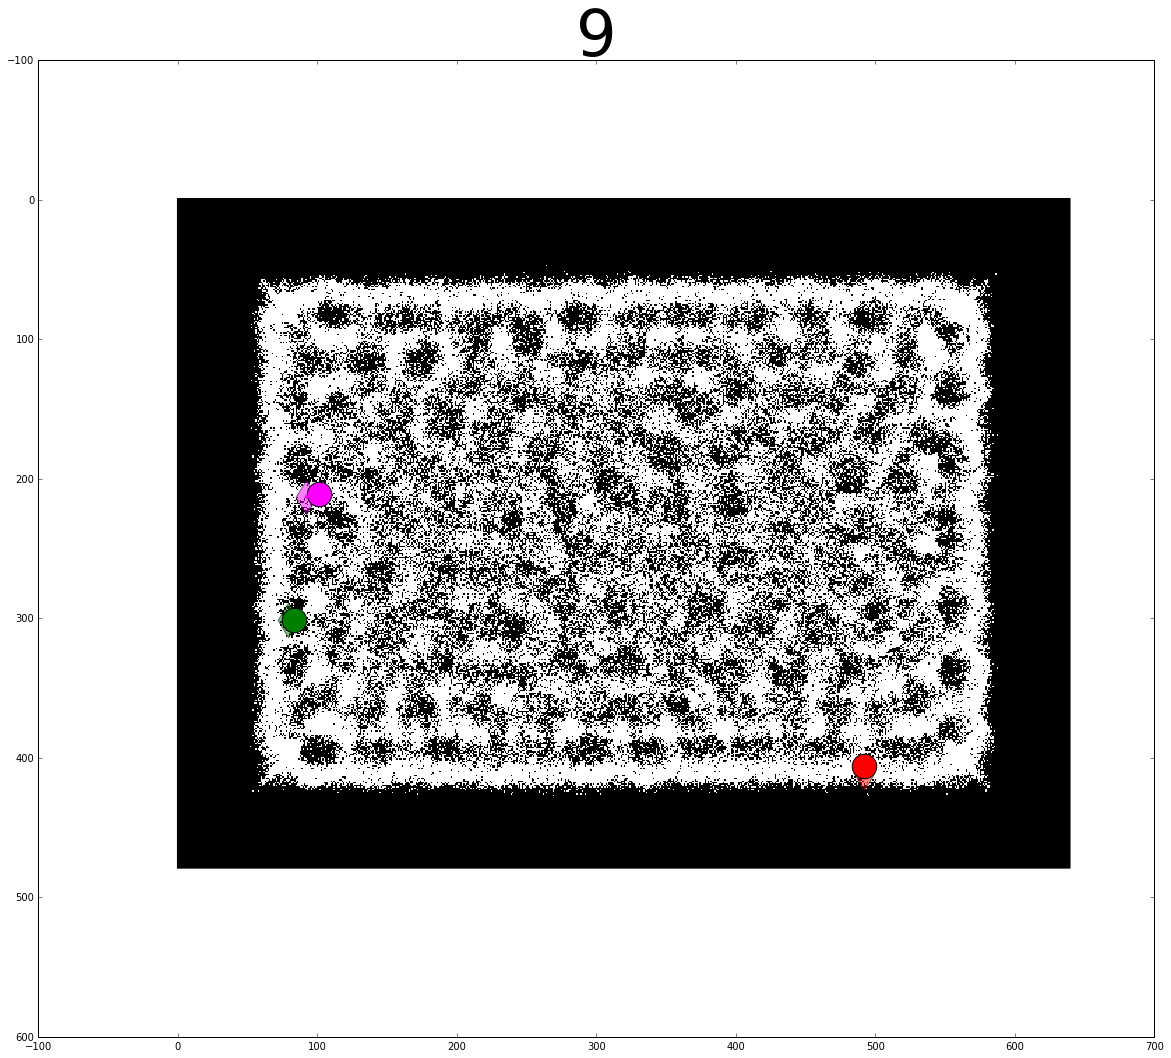

10


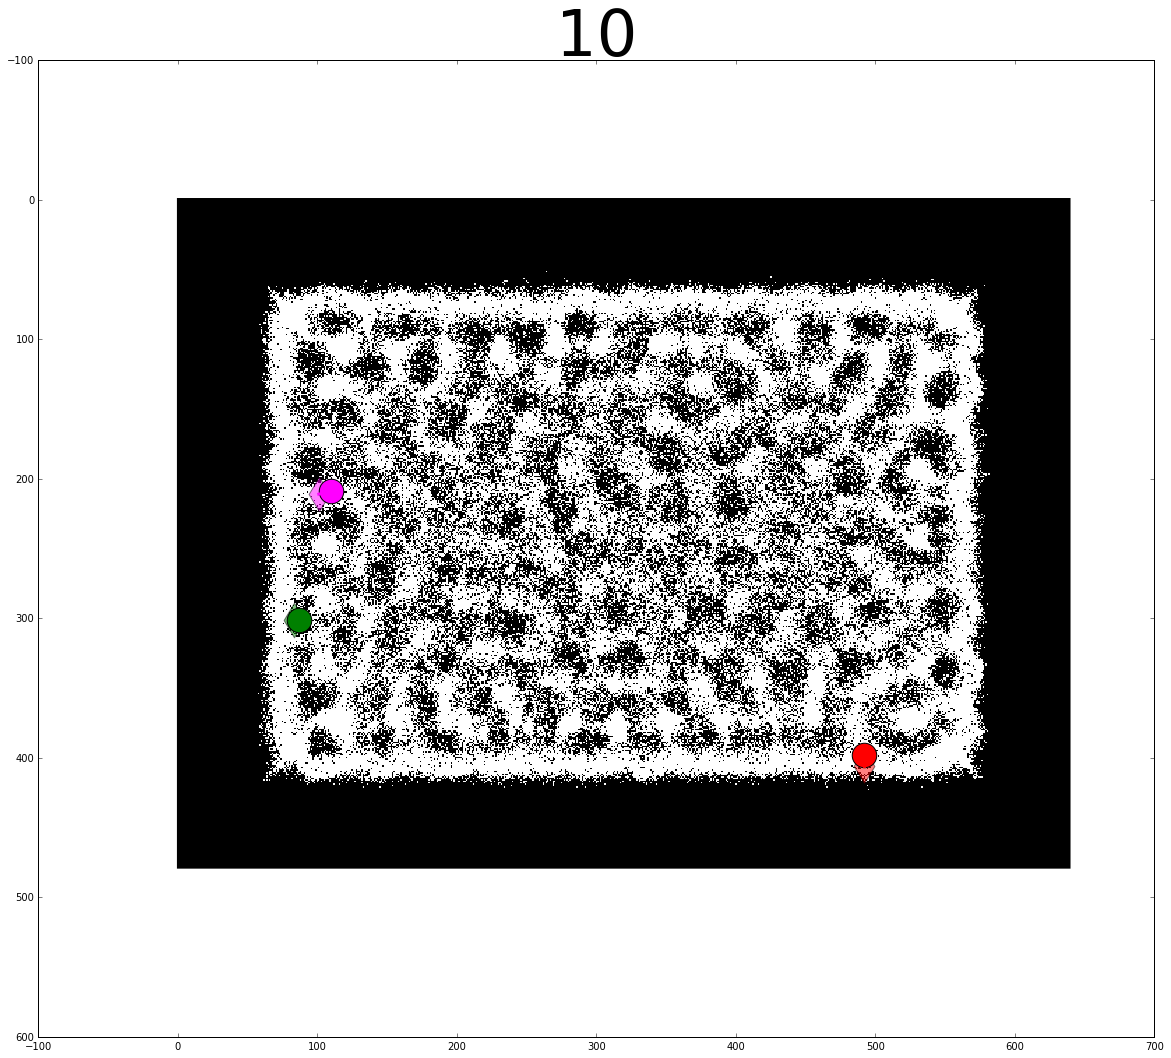

11


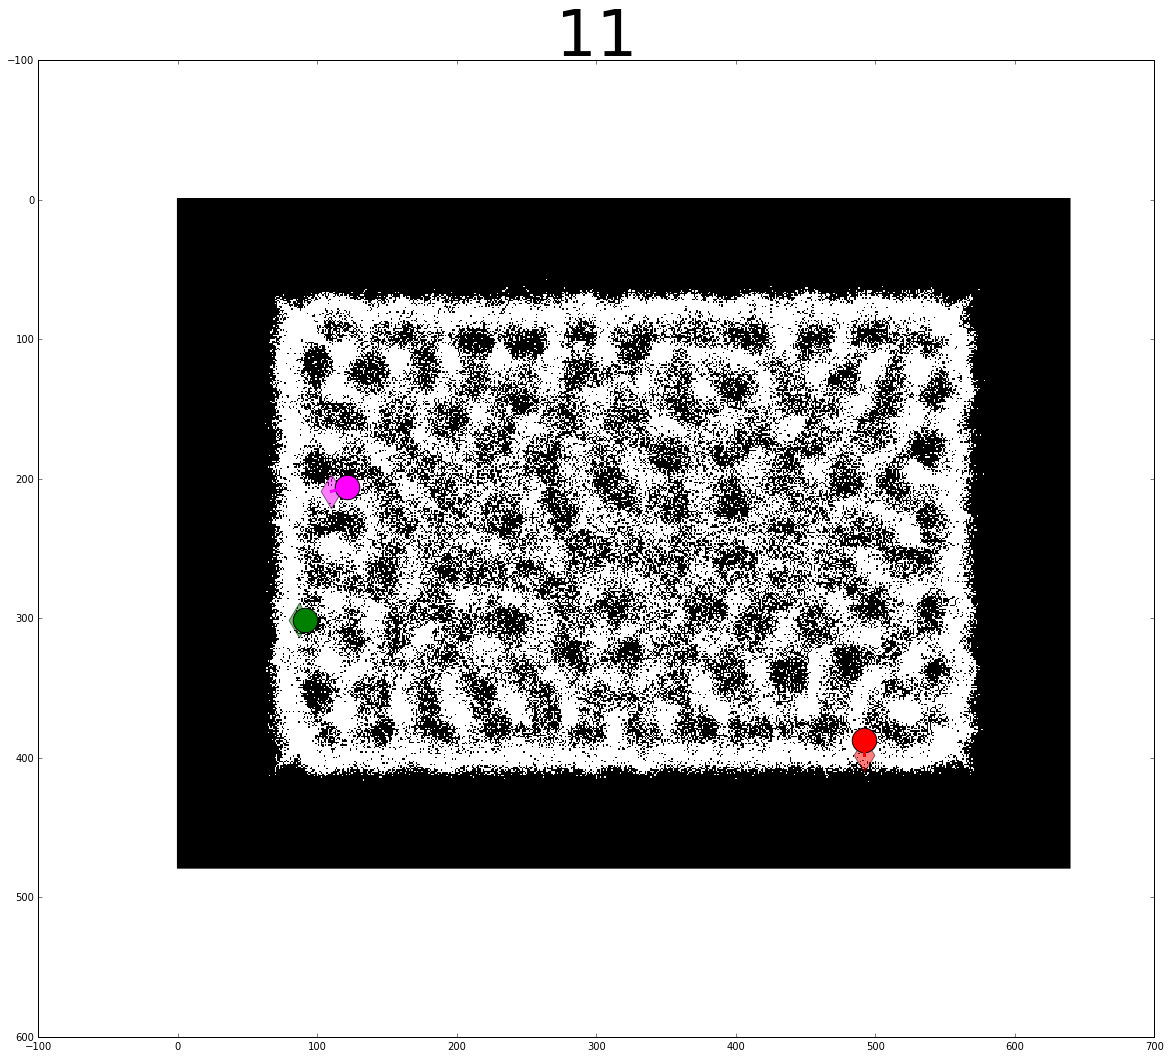

12


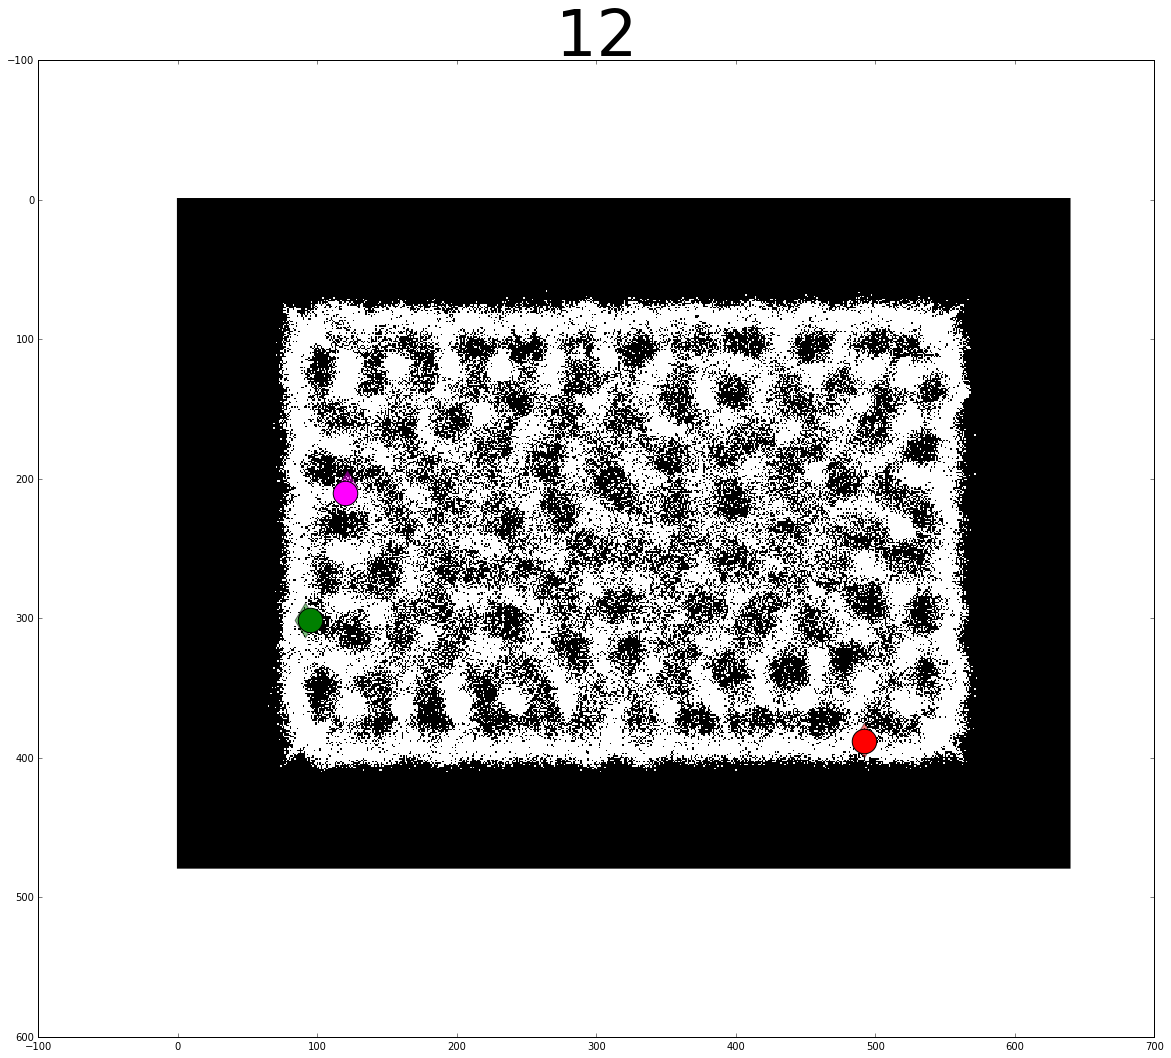

13


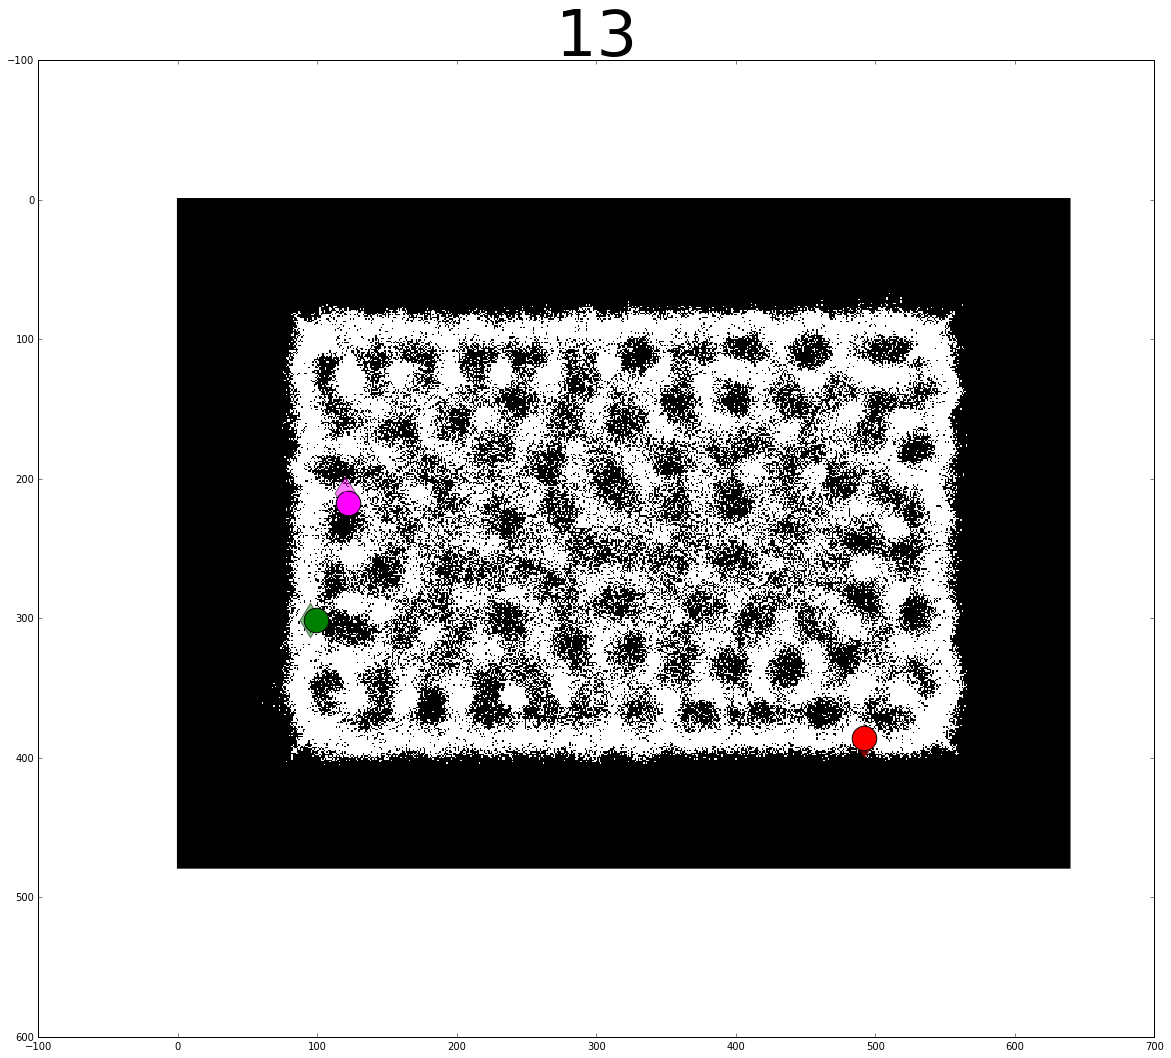

14


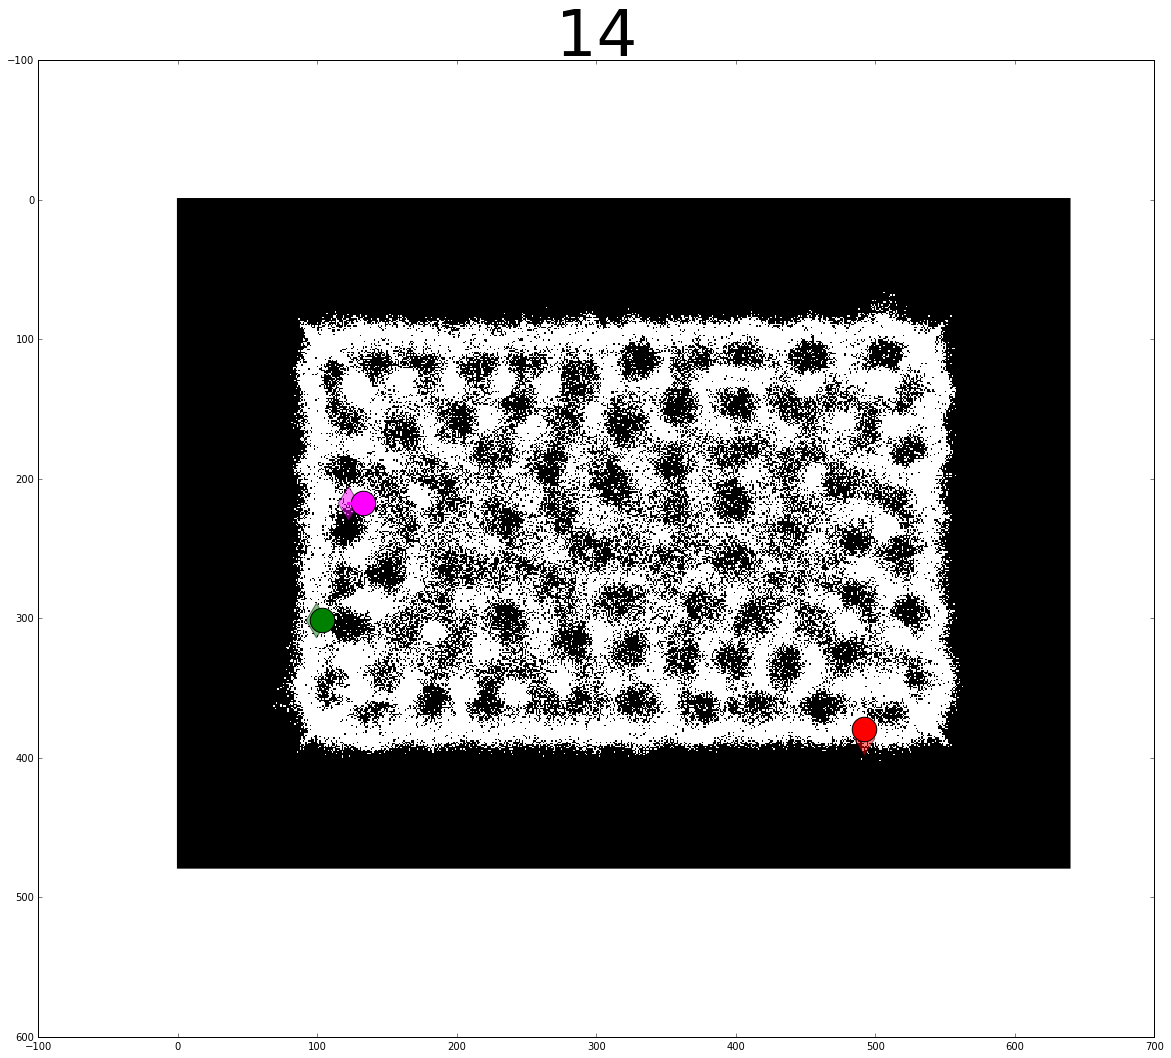

In [11]:
num = 640 * 480
resolution = [480, 640, 1]

starlings = init_data(num, resolution)
world = form_world(starlings, resolution)

opcl = OpenCl()

count = 0

inner_rad = np.int32(30)
# inner_rad = np.int32(16)
outer_rad = np.int32(32)

stop = 10 * 1.5

frames = []

fi = 50

while count < stop:

    draw(starlings, resolution, count)
#     if count % 1000 == 0:
#         print count
    print count
    
    plot_(starlings, resolution, count).show()
    frames.append(starlings)
    
    try:
        starlings = opcl.execute(num, starlings, world, inner_rad, outer_rad)
    except cl.RuntimeError, e:
        print str(e)
        np.set_printoptions(threshold=np.nan, linewidth=512)
        print starlings[:,0:15]
        if filepath and filepath[0]:
            save_as_hd5(starlings, resolution, filepath[0])
        else:
            save_as_hd5(starlings, resolution)
        raise
    world = form_world(starlings, resolution)

    count += 1

In [12]:
# def angle_vector(a,b):
#     dot_a_b = np.einsum('ij,ij->i', a, b)
#     dot_a_a = np.einsum('ij,ij->i', a, a)
#     dot_b_b = np.einsum('ij,ij->i', b, b)
#     angle = np.arccos(dot_a_b/(np.sqrt(dot_a_a)*np.sqrt(dot_b_b)))
#     np.where()
    
# def color_from_angle(vel):
#     size = np.linalg.norm(vel, axis=1)
#     stator = np.zeros_like(vel, dtype=np.float)
#     stator[:,0] = size
    
#     angle = angle_vector(vel, stator)
    
#     ratio = angle / (2 * np.pi)
    
#     #8 bit
#     max_color_arr = np.asarray([255,255,255])
#     max_color = np.prod(max_color_arr)
#     color = ratio * max_color
#     color_arr = np.zeros_like(vel)
#     for d in np.arange(max_color_arr.shape[0]):
#         color_arr[:,d] = (color[:] / np.prod(max_color_arr[:d])) % max_color_arr[d] 
#     return color_arr

def color_from_vel(vel):
    size = np.linalg.norm(vel, axis=1)
    max_vel = size.max()
    ratio = size / max_vel
    
    max_color_arr = np.asarray([128,128,128])
    max_color = np.prod(max_color_arr)
    color = ratio * max_color
    color_arr = np.zeros_like(vel)
    for d in np.arange(max_color_arr.shape[0]):
        color_arr[:,d] = (color[:] / np.prod(max_color_arr[:d])) % max_color_arr[d] 
    
    return color_arr[...,::-1]
    

In [13]:
def plot_(starlings, resolution, count):
    plt.figure(figsize = (20,20))
    
    plt.imshow(im(starlings,resolution,col=color_from_vel(starlings[:,3:6])), interpolation='nearest')
    
    plt.plot([starlings[1066,1],(starlings[1066,1] - starlings[1066,4])], 
             [starlings[1066,0],(starlings[1066,0] - starlings[1066,3])], 
             lw="3", c='red')
    plt.plot([starlings[1067,1],(starlings[1067,1] - starlings[1067,4])], 
             [starlings[1067,0],(starlings[1067,0] - starlings[1067,3])], 
             lw="3", c='green')
    plt.plot([starlings[1068,1],(starlings[1068,1] - starlings[1068,4])], 
             [starlings[1068,0],(starlings[1068,0] - starlings[1068,3])]
             , lw="3", c='magenta')
    
    plt.scatter((starlings[1066,1] - starlings[1066,4]),
                (starlings[1066,0] - starlings[1066,3]), 
                s=600, c='red', alpha=.5, marker='d')
    plt.scatter((starlings[1067,1] - starlings[1067,4]),
                (starlings[1067,0] - starlings[1067,3]), 
                s=600, c='green', alpha=.5, marker='d')
    plt.scatter((starlings[1068,1] - starlings[1068,4]),
                (starlings[1068,0] - starlings[1068,3]), 
                s=600, c='magenta', alpha=.5, marker='d')
    
    plt.scatter(starlings[1066,1], starlings[1066,0], s=600, c='red', )
    plt.scatter(starlings[1067,1], starlings[1067,0], s=600, c='green')
    plt.scatter(starlings[1068,1], starlings[1068,0], s=600, c='magenta')
    
    plt.title(str(count), size=64)
    
    return plt

In [14]:
def draw(population, resolution, count):
    filename = './out/image/frame_{0:05d}.png'.format(count)
    
    res_x = resolution[0]
    res_y = resolution[1]

    flat_world = np.zeros((res_x, res_y,3), dtype=np.int8)
    flat_world[population[:,0],population[:,1]] = color_from_vel(population[:,3:6])
    
    scp.toimage(flat_world, cmin=0, cmax=255).save(filename)

In [19]:
num = 640 * 480
resolution = [480, 640, 1]

starlings = init_data(num, resolution)
world = form_world(starlings, resolution)

opcl = OpenCl()

count = 0

inner_rad = np.int32(30)
# inner_rad = np.int32(16)
outer_rad = np.int32(32)

stop = 256

frames = []

fi = 50

In [20]:
while count < stop:

    draw(starlings, resolution, count)
#     if count % 1000 == 0:
#         print count
    print count

#     plot_(starlings, resolution, count).show()
    frames.append(starlings)
    
    try:
        starlings = opcl.execute(num, starlings, world, inner_rad, outer_rad)
    except cl.RuntimeError, e:
        print str(e)
        np.set_printoptions(threshold=np.nan, linewidth=512)
        print starlings[:,0:15]
        if filepath and filepath[0]:
            save_as_hd5(starlings, resolution, filepath[0])
        else:
            save_as_hd5(starlings, resolution)
        raise
    world = form_world(starlings, resolution)

    count += 1

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
